In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
from matplotlib import pylab as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size
plt.rc("animation", html="html5")
import random
random.seed(0)
import numpy as np
np.random.seed(0)
from pathlib import Path

In [2]:
from collections import defaultdict
import random
from negmas import ResponseType, SAOResponse
from scml.oneshot import *
from scml.oneshot.common import is_system_agent
from pprint import pprint

def try_agent(agent_type, n_processes=2, **kwargs):
    """Runs an agent in a world simulation against a randomly behaving agent"""
    return try_agents([RandomOneShotAgent, agent_type], n_processes,**kwargs)

def try_agents(agent_types, n_processes=2, n_trials=5, draw=True, agent_params=None, year=2024):
    """
    Runs a simulation with the given agent_types, and n_processes n_trial times.
    Optionally also draws a graph showing what happened
    """
    type_scores = defaultdict(float)
    counts = defaultdict(int)
    agent_scores = dict()
    for _ in range(n_trials):
        p = n_processes if isinstance(n_processes, int) else random.randint(*n_processes)
        cls = {2022:SCML2022OneShotWorld, 2023: SCML2023OneShotWorld, 2024: SCML2024OneShotWorld}[year]
        world = cls(
        **cls.generate(agent_types, agent_params=agent_params, n_steps=10, 
                       n_processes=p, random_agent_types=True), construct_graphs=True,)
        world.run()

        all_scores = world.scores()
        for aid, agent in world.agents.items():
            if is_system_agent(aid):
                continue
            key = aid if n_trials == 1 else f"{aid}@{world.id[:4]}"
            agent_scores[key] = (
                 agent.type_name.split(':')[-1].split('.')[-1],
                 all_scores[aid],
                 '(bankrupt)' if world.is_bankrupt[aid] else ''
                )
        for aid, agent in world.agents.items():
            if is_system_agent(aid):
                continue
            type_ = agent.type_name.split(':')[-1].split('.')[-1]
            type_scores[type_] += all_scores[aid]
            counts[type_] += 1
    type_scores = {k: v/counts[k] if counts[k] else v for k, v in type_scores.items()}
    if draw:
        world.draw(
            what=["contracts-concluded"],
            steps=(0, world.n_steps - 1),
            together=True, ncols=1, figsize=(20, 20)
        )
        plt.show()

    return world, agent_scores, type_scores

def analyze_contracts(world):
    """
    Analyzes the contracts signed in the given world
    """
    import pandas as pd
    data = pd.DataFrame.from_records(world.saved_contracts)
    return data.groupby(["seller_name", "buyer_name"])[["quantity", "unit_price"]].mean()


def print_agent_scores(agent_scores):
    """
    Prints scores of individiual agent instances
    """
    for aid, (type_, score, bankrupt) in agent_scores.items():
        print(f"Agent {aid} of type {type_} has a final score of {score} {bankrupt}")

def print_type_scores(type_scores):
    """Prints scores of agent types"""
    pprint(sorted(tuple(type_scores.items()), key=lambda x: -x[1]))

## Developing an agent using RL (new in 2024)

The SCML game provides a new and interesting challenge for reinforcement learning and multi-agent reinforcement learning research. The main challenges in this game are:

1. Each world is different which means that a single policy is not likely to work effectively in all worlds. This means that it may be beneficial to train multiple RL agents and design a way to switch between them depending on the situation. This approach was shown to be effective in simple automated negotiations [before](https://arxiv.org/pdf/2102.03588).
2. The environment is partially observable because the agent has no access to the state of other agents. 
3. The environment is not deterministic because different penalties and exogenous contracts are sampled from probabilistic distributions and do affect the behavior of all agents in the environment.
4. The state space is huge. The information available to the agent through the `awi` despite being partial is still large enough that just passing everything to the RL training algorithm is not likely to work. 
5. Reward is sparce. No rewards of anykind are received - natively - during negotiations. The only rewards received by the agent are changes in its balance calculated at the end of every simulated day.

The SCML game is a realistic game for which any advance can readily be translated into a real-world application. Some of the best peforming agents in past iterations of SCML (OneShot) did use RL in some capacity. It was difficult to develop these agents because no native support was provided. In SCML 2024, we provide native support for developing RL agents both for the OneShot and Standard tracks. This tutorial walks you through the process involved in developing, training, and submitting a simple RL agent for SCML 2024 OneShot. The process is exactly the same for the standard track.

### Moving Pieces

![SCML RL Components](rl.jpg)



RL support in SCML depends on multiple simple components. This section of the tutorial introduces all the moving pieces and describe how they fit together.  

As is always the case in RL, we need the following components: An **environment** which represents the game, an **agent** (or multiple agents) that that receive **observations** from the environment and return **actions** to it, and a **reward function** which provides feedback to the agent (during training).

These directly translate to the components of the RL subsystem of SCML:

1. **OneShotEnv** is the environment which instantiates `OneShotWorld`s that represent the negotiation. The agent is represented within this environment with a [OneShotDummyAgent](https://scml.readthedocs.io/en/latest/api/scml.oneshot.OneShotDummyAgent.html#oneshotdummyagent) which just acts a placeholder for the RL agent interacting with this environment. You do not need to modify this placeholder agent or touch the environment. The environment keeps track of the rest of the components as well and uses them to interact with the true `OneShotRLAgent` developed by the participant. These are the `RewardFunction`, `ObservactionManger` and `ActionManager`.

### Developing an RL agent for SCML

The first step is to decide the contexts you are going to use for your RL agent. As explained above, an RL agent can use multiple models depending on the context it finds itself in. In this example we use two contexts, one for $L_0$ agents and another for $L_1$ agents.

#### Context Design
The function `make_context` below can be used to create either of these contexts:

In [3]:
N_SUPPLIERS = (1, 8)
N_CONSUMERS = (1, 8)
def make_context(as_supplier: bool):
    """Generates a context for the agent acting as a supplier or as a consumer"""
    n_agents_per_level = (
        min(N_SUPPLIERS[0], N_CONSUMERS[0]),  # type: ignore
        max(N_SUPPLIERS[1], N_CONSUMERS[1]),  # type: ignore
    )
    if as_supplier:
        return LimitedPartnerNumbersOneShotContext(
            n_suppliers=(0, 0),  # suppliers have no suppliers
            n_consumers=N_CONSUMERS,
            n_competitors=(N_SUPPLIERS[0] - 1, N_SUPPLIERS[1] - 1),
            n_agents_per_level=n_agents_per_level,
            level=0,  # suppliers are always in the first level
        )

    return LimitedPartnerNumbersOneShotContext(
        n_suppliers=N_SUPPLIERS,
        n_consumers=(0, 0),  # consumers have no consumers
        n_competitors=(N_CONSUMERS[0] - 1, N_CONSUMERS[1] - 1),
        n_agents_per_level=n_agents_per_level,
        level=-1,  # consumers are always in the last level
    )

#### Observation Manager Design

The second step, is to decide what observations are we going to get from the environment. This is the responsibility of the `ObservationManager`. Here we simply use one of the built-in observation managers.

<div class="alert alert-block alert-warning">
    The built-in observation manager is just a baseline that is not expected to behave well. Please be sure to design your own observation manager. You can use the code of the built-in observation manager as an example.
</div>

Our observation manager is implemented by `MyObservationManager` in which we show all the methods that you need to implement for your observation manager. 

In [4]:
from gymnasium import spaces

class MyObservationManager(LimitedPartnerNumbersObservationManager):
    """This is my observation manager implementing encoding and decoding the state used by the RL algorithm"""

    def make_space(self) -> spaces.Space:
        """Creates the observation space"""
        return super().make_space()

    def encode(self, state: OneShotState) -> np.ndarray:
        """Encodes an observation from the agent's state"""
        return super().encode(state)

    def make_first_observation(self, awi: OneShotAWI) -> np.ndarray:
        """Creates the initial observation (returned from gym's reset())"""
        return super().make_first_observation(awi)

    def get_offers(
        self, awi: OneShotAWI, encoded: np.ndarray
    ) -> dict[str, SAOResponse]:
        """Gets the offers from an encoded state"""
        return super().get_offers(awi, encoded)

#### Training

Now that we have a way to observe the environment, we can train two models for our two contexts. `train_models()` below achieves this by simply creating an environment for each context, instantiate an A2C trainer (from the stable_baselines3 library) and calls its `learn()` method to train the model. The two learned models are then returned.

In [5]:
from stable_baselines3 import A2C
from scml.oneshot.rl.action import UnconstrainedActionManager
from scml.oneshot.rl.agent import OneShotRLAgent
from scml.oneshot.rl.env import OneShotEnv


def train_models(type_ = "limited", n_training=100):
    # choose the type of the model. Possibilities supported are:
    # fixed: Supports a single world configuration
    # limited: Supports a limited range of world configuration
    # unlimited: Supports any range of world configurations

    def make_env(supplier, extra_checks: bool = False) -> OneShotEnv:
        context = make_context(supplier)
        return OneShotEnv(
            action_manager=UnconstrainedActionManager(context=context),
            observation_manager=MyObservationManager(
                context=context, extra_checks=extra_checks
            ),
            context=context,
            extra_checks=False,
        )
    models = []
    for as_supplier in (False, True):
        suffix = 'supplier' if as_supplier else 'consumer'
        print(f"Training as {suffix}")
        # create a gymnasium environment for training
        env = make_env(as_supplier, extra_checks=True)

        # choose a training algorithm
        model = A2C("MlpPolicy", env, verbose=0)

        # train the model
        model.learn(total_timesteps=n_training, progress_bar=True)
        print(f"\tFinished training the model for {n_training} steps")
        models.append(model)
    return models

We can now train our models

In [6]:
trained_models = train_models()

Training as consumer


Output()

	Finished training the model for 100 steps
Training as supplier


Output()

	Finished training the model for 100 steps


#### Creating the Agent

The final step is to create our agent class `MyAgent`. This class simply inherits from the `OneShotRLAgent` class and updates the initialization paratmers to use the models we just trained. Note that each model should be wrapped in a `Policy` object which is done by the `model_wrapper` method below. Also note that we use pass our observation manager to the base `OneShotRLAgent` alongside the model.

<div class="alert alert-block alert-info">
    It is possible to use different observation managers for differnt models. 
    <br>
    Make sure that the context used to train the model is the same as the one used for the observation manager.
</div>

In [7]:
from scml.oneshot.rl.common import model_wrapper
class MyAgent(OneShotRLAgent):
    """
    This is the only class you *need* to implement. The current skeleton simply loads a single model
    that is supposed to be saved in MODEL_PATH (train.py can be used to train such a model).
    """

    def __init__(self, *args, trainde_models=trained_models, **kwargs):    
        # update keyword arguments
        kwargs.update(
            dict(
                # load models from MODEL_PATH
                models=tuple(model_wrapper(_) for _ in trained_models),
                # create corresponding observation managers
                observation_managers=(
                    MyObservationManager(context=make_context(True)),
                    MyObservationManager(context=make_context(False)),
                ),
            )
        )
        # Initialize the base OneShotRLAgent with model paths and observation managers.
        super().__init__(*args, **kwargs)

Now we can have an agent that can be tested as we did in the previous tutorial:

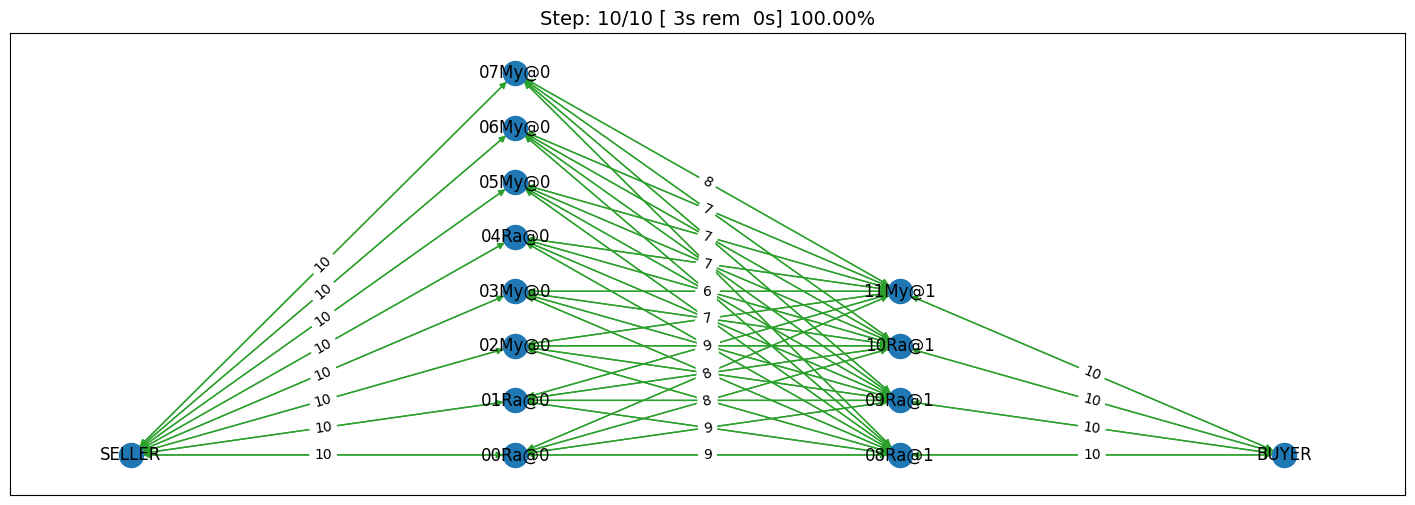

[('MyAgent', 0.2644756136918184), ('RandomOneShotAgent', 0.21216318723722566)]


In [8]:
world, ascores, tscores = try_agent(MyAgent)
print_type_scores(tscores)

#### What next?

As expected, the trained model is too weak for several reasons:

1. We trained it for only few steps (not even a complete world simulation). You will want to increase the number of steps during training.
2. The contexts we used are too general. A supplier with one other competitor and ten consumers is in a situation that is very different than one with ten other competitors and two consumers. You may need to think more carefully about what contexts makes sense for this problem.
3. The observation manager just does not make much sense. The built-in observation manager keeps track of the offers received and just few other parameters from the environment. This is not enough most likely to train a strong agent. Maybe, most of your time will be spent trying to comeup with good observation managers.
4. The reward function received by the agent during training is simply the profit/loss acrued every day. This is too sparse as there is no signal during negotiations. You may consider doing reward shaping by creating a reward function and passing it to the environment used in training.